In [1]:
#basic package
import json
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import shutil
import time
import datetime as dt
import itertools
import time
import re
from collections import Counter
from collections import defaultdict
import operator
import math
from scipy import stats
import pickle
from collections import Counter

#modelling
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

#plot
import matplotlib
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, acf, pacf

from matplotlib.collections import LineCollection
from matplotlib.colors import BoundaryNorm
import seaborn as sns

c:\users\camil\anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from UTILS import perc_element_dico
import config_mobility as config

c:\users\camil\anaconda3\lib\site-packages\_pytest\fixtures.py:844: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  params = attr.ib(convert=attr.converters.optional(tuple))
c:\users\camil\anaconda3\lib\site-packages\_pytest\fixtures.py:846: DeprecationWarning: The `convert` argument is deprecated in favor of `converter`.  It will be removed after 2019/01.
  ids = attr.ib(default=None, convert=_ensure_immutable_ids)
c:\users\camil\anaconda3\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


we restrict the time series to one value per 60 seconds 
we compute the complexity variables each 30 minutes 
each variables includes the values of at least the last 120.00 minutes (i.e. are using 120.00 values)


In [3]:
#comment on this run of the script
comment = ''

### choose hybrid type
type_hybrid = 'LB' #LSL, all, LB

### choose type of word definition
type_ = 'fixedLength' ; length_words = 3 ; comment = comment+'lengthwords_'+str(length_words)
#type_ = 'varyinglength' ; morethan4_in1 = True ; comment = comment+'_morethan4in1_'+str(int(morethan4_in1))

### choose session to take into account
Sess2keep = [1,2,3]
#li_sess = [[1,2,3],[2,3,4],[3,4,5],[4,5,6],[5,6,7],[6,7,8],[7,8,9],[8,9,10],[9,10,11]]
#Sess2keep = [9,10,11]

### unique naming
title_ = type_hybrid+'---'+type_+'---'+comment+'---sess_'+'_'.join([str(x) for x in Sess2keep]) 
#'_LB', '_all','_LSL' '_LB_newword_def' '_all_newword_def'
print('The topic modeling used is named: '+title_)

The topic modeling used is named: LB---fixedLength---lengthwords_3---sess_1_2_3


In [4]:
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
path_save_ = os.path.join(path_extracted_data, 'visual', 'predict_KBF', title_)
#create a director if not existinga
if not os.path.exists(path_save_):
    os.makedirs(path_save_)

# Data at KBF level

In [5]:
df_master = pd.read_csv(os.path.join(path_initial_data,'Mo_Masterfile.csv'), sep=';', parse_dates=['day']) #, parse_dates=['date']) wrong!
df_master.rename(columns={'time':'Timestamp','day':'DayID','hen':'HenID','date':'day'}, inplace=True)
#dico or join by hen (not day as some are nan but we actually know then)
df_master['day'] = df_master['day'].map(lambda x: dt.datetime.strptime(x, "%d.%m.%Y"))
df_master['HenID'] = df_master['HenID'].map(str)
dico_hen_group = dict(zip(df_master['HenID'].tolist(), df_master['group'].tolist()))
df_master['HenID'] = df_master['HenID'].map(lambda x: 'hen_'+str(x))
#df_master.filter(['HenID','group'])
print(df_master.shape)
df_master.head(3)

(7920, 43)


,HenID,timepoint,group,age,DayID,day,file,severity,pen,hybrid,...,meanchange,mean1,medianchange,transitions,real0,sumdur,nest_vs_total,severity_diff,KBF_new,indicator
0,hen_1,1,A,21,1,2016-10-27,1A01,0.0,1,LSL,...,1.23,1.0,1.0,91.0,NaN,57067.0,0.177419,NaN,0.0,NaN
1,hen_1,1,A,21,2,2016-10-28,1A01,0.0,1,LSL,...,1.28,1.0,1.0,108.0,NaN,56854.0,0.171053,0.0,0.0,NaN
2,hen_1,1,A,21,3,2016-10-29,1A01,0.0,1,LSL,...,1.17,1.0,1.0,128.0,NaN,56721.0,0.255319,0.0,0.0,NaN


0.0    373
1.0    332
Name: gap, dtype: int64

c:\users\camil\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)
c:\users\camil\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


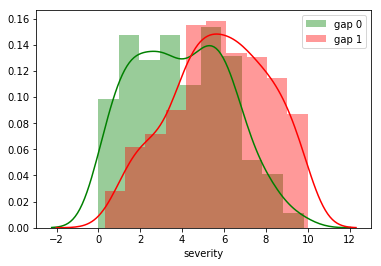

In [6]:
#gap variable
df_ = df_master[['gap','severity','timepoint']].drop_duplicates(subset=None, keep='first', inplace=False)
display(df_['gap'].value_counts())
df_[df_['gap']==0]['severity']
sns.distplot( df_[df_['gap']==0]['severity'] , color="green", label="gap 0")
sns.distplot( df_[df_['gap']==1]['severity'] , color="red", label="gap 1")
plt.legend();
plt.savefig(os.path.join(path_extracted_data, 'visual', 'severity histogram per gap.png'),dpi=300,bbox_inches='tight')
plt.show()

In [7]:
#create dico to match each day to the session and number of days of the session
df_ = df_master.groupby('timepoint')['day'].agg(lambda x: sorted(set(x))).reset_index()
dico_day_sessiontpt = {}
for tpt in df_master['timepoint'].unique():
    li_d = df_[df_['timepoint']==tpt]['day'].values[0]
    for i,d in enumerate(li_d):
        dico_day_sessiontpt[d] = 'sess_'+str(tpt)+'_day'+str(i%6) #modulo 6 to take into account groups A and B
#dico_day_sessiontpt

In [8]:
df_kbf = df_master[['HenID','severity','gap','timepoint','hybrid']].copy()
df_kbf = df_kbf.drop_duplicates(subset=None, keep='first', inplace=False)
print(df_kbf.shape)
df_kbf.head(3)

(1320, 5)


,HenID,severity,gap,timepoint,hybrid
0,hen_1,0.0,0.0,1,LSL
6,hen_1,0.0,0.0,2,LSL
12,hen_1,0.8,0.0,3,LSL


In [9]:
#dico to match henID to hybrid
dico_henid_hybrid = dict(zip(df_kbf['HenID'].tolist(),df_kbf['hybrid'].tolist()))
li_LB = df_master[df_master['hybrid']=='LB']['HenID'].unique()
li_LSL = df_master[df_master['hybrid']=='LSL']['HenID'].unique()
print(len(li_LB), len(li_LSL))
li_LB[0:2]

60 60


array(['hen_41', 'hen_42'], dtype=object)

# Data at day level

### topic modelling

In [10]:
#add all topic modelling into one dataframe
li_dflda = []
min_topic = 2
li_path = glob.glob(os.path.join(path_extracted_data,'visual','TM', title_, '*'))
max_topic = max([int(x.split('\\')[-1]) for x in li_path if x.split('\\')[-1].isdigit()])
df_all_lda = pd.DataFrame(columns=['day','HenID'])
for nbr_topics_ in tqdm.tqdm(range(min_topic,max_topic+1)):
    print(df_all_lda.shape)
    path_save = os.path.join(path_extracted_data,'visual','TM', title_, str(nbr_topics_))
    df_lda = pd.read_csv(os.path.join(path_save,'df_topics'+str(nbr_topics_)+'.csv'), sep=';',parse_dates=['day']) 
    #print(df_lda.shape)
    #df_lda.head(3)
    df_lda['topic'] = df_lda['topic'].map(lambda x: 'topic_'+str(x))
    #lets take the topic distribution / main topic of the clustering with k=6-15 over all the days of the first session
    li_sorted_days = df_lda.sort_values(['day'],ascending=True)['day'].unique()
    li_topics = [x for x in df_lda.columns if (x.startswith('topic')) & (x!='topic_info')]
    dico_topics_newtopics = {c:'k'+str(nbr_topics_)+'_'+ c for c in li_topics}
    df_lda.rename(columns=dico_topics_newtopics, inplace=True)
    df_all_lda = pd.merge(df_all_lda, df_lda[['HenID','day']+list(dico_topics_newtopics.values())], on=['HenID','day'], 
                          how='outer')
print(df_all_lda.shape)
df_all_lda.head(3)

  0%|                                                                                           | 0/18 [00:00<?, ?it/s]

(0, 2)


  6%|████▌                                                                              | 1/18 [00:00<00:02,  6.25it/s]

(1046, 6)


 11%|█████████▏                                                                         | 2/18 [00:00<00:02,  6.28it/s]

(1046, 11)


 17%|█████████████▊                                                                     | 3/18 [00:00<00:02,  6.32it/s]

(1046, 17)


 22%|██████████████████▍                                                                | 4/18 [00:00<00:02,  6.20it/s]

(1046, 24)


 28%|███████████████████████                                                            | 5/18 [00:00<00:02,  6.15it/s]

(1046, 32)


 33%|███████████████████████████▋                                                       | 6/18 [00:00<00:01,  6.18it/s]

(1046, 41)


 39%|████████████████████████████████▎                                                  | 7/18 [00:01<00:01,  6.11it/s]

(1046, 51)


 44%|████████████████████████████████████▉                                              | 8/18 [00:01<00:01,  6.17it/s]

(1046, 62)


 50%|█████████████████████████████████████████▌                                         | 9/18 [00:01<00:01,  6.20it/s]

(1046, 74)


 56%|█████████████████████████████████████████████▌                                    | 10/18 [00:01<00:01,  5.88it/s]

(1046, 87)


 61%|██████████████████████████████████████████████████                                | 11/18 [00:01<00:01,  5.99it/s]

(1046, 101)


 67%|██████████████████████████████████████████████████████▋                           | 12/18 [00:01<00:01,  5.85it/s]

(1046, 116)


 72%|███████████████████████████████████████████████████████████▏                      | 13/18 [00:02<00:00,  5.96it/s]

(1046, 132)


 78%|███████████████████████████████████████████████████████████████▊                  | 14/18 [00:02<00:00,  6.05it/s]

(1046, 149)


 83%|████████████████████████████████████████████████████████████████████▎             | 15/18 [00:02<00:00,  6.11it/s]

(1046, 167)


 89%|████████████████████████████████████████████████████████████████████████▉         | 16/18 [00:02<00:00,  5.97it/s]

(1046, 186)


 94%|█████████████████████████████████████████████████████████████████████████████▍    | 17/18 [00:02<00:00,  5.89it/s]

(1046, 206)


100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  5.94it/s]


(1046, 227)


,HenID,day,k2_topic,k2_topic_proba,k2_topic_0_proba,k2_topic_1_proba,k3_topic,k3_topic_proba,k3_topic_0_proba,k3_topic_1_proba,...,k19_topic_9_proba,k19_topic_10_proba,k19_topic_11_proba,k19_topic_12_proba,k19_topic_13_proba,k19_topic_14_proba,k19_topic_15_proba,k19_topic_16_proba,k19_topic_17_proba,k19_topic_18_proba
0,hen_41,2016-10-27,topic_0,0.994596,0.994596,0.000000,topic_1,0.991471,0.000000,0.991471,...,0.0,0.0,0.021021,0.000000,0.077328,0.00000,0.00000,0.035849,0.231746,0.0
1,hen_42,2016-10-27,topic_1,0.668679,0.331321,0.668679,topic_0,0.791857,0.791857,0.081771,...,0.0,0.0,0.000000,0.000000,0.042264,0.06204,0.34214,0.000000,0.096535,0.0
2,hen_43,2016-10-27,topic_1,0.588518,0.411482,0.588518,topic_0,0.993386,0.993386,0.000000,...,0.0,0.0,0.000000,0.465637,0.069269,0.00000,0.23415,0.000000,0.056248,0.0


## egg shift

df_shift = pd.read_csv(os.path.join(path_save_,id_run+'df_acf_pacf_session_summary.csv'), sep=';')
display(df_shift.head(3))
#dico_hen_nbrunsign = dict(df_shift.groupby(['HenID'])['pacf_confintdifference'].agg(lambda x: sum([i<=0.1 for i in x])))
#keep only with 60mn
#df_shift = df_shift[df_shift['mn']==60]
df_shift.loc[df_shift['pacf_value']==0,'pacf_confintdifference'] = 100
#remove not strong significicant pacf
df_shift = df_shift[df_shift['pacf_confintdifference']>0.1]

df_shift['pacf_value'] = df_shift['pacf_value'].map(lambda x: round(x))
li_val = df_shift['pacf_value'].unique()
#extract variables
fct2apply = {'pacf_variance':lambda x: round(np.var(x),3),
            'pacf_dico':lambda x: perc_element_dico(x)}
df_shift = df_shift.groupby(['HenID'])['pacf_value'].agg(fct2apply).reset_index()
for v in li_val:
    df_shift['pacf_perc_'+str(int(v))] = df_shift['pacf_dico'].map(lambda x: round(x.get(float(v),0.0),3))
df_shift['perc_before24'] = df_shift['pacf_dico'].map(lambda x: sum([v for k,v in x.items() if ((k<24)&(k!=0))]))
df_shift['perc_after24'] = df_shift['pacf_dico'].map(lambda x: sum([v for k,v in x.items() if k>24]))
#df_shift['nbr_unsign'] = df_shift['HenID'].map(lambda x: dico_hen_nbrunsign[x])
#df_shift.drop(columns=['pacf_dico'], inplace=True)
print(df_shift.shape)
display(df_shift.head(3))
df_shift[['perc_before24','pacf_perc_0','pacf_perc_24','perc_after24']].head(3)

## MLPS session metrics

In [11]:
li_path = glob.glob(os.path.join(path_extracted_data,'VF_time_serie_day_*_variables_SIMPLER.csv'))
li_zone = ['zone_1', 'zone_2', 'zone_3', 'zone_4', 'zone_5']
li_df = []
for path_ in li_path:
    sessID = path_.split('_')[-3]
    df_ = pd.read_csv(path_, sep=';', index_col=0, parse_dates=['level','FirstTimestamp_zone_1','FirstTimestamp_zone_2',
                                                                'FirstTimestamp_zone_3','FirstTimestamp_zone_4',
                                                                'FirstTimestamp_zone_5'])
    #day 2017-08-07 egg quality must be linked to the MLPs variable of the day 2017-08-06 with possible bias induce by if the hen 
    #laid the egg at 9h on the 2017-08-06 (or anytime after 8h, the time where the people take the egg). 
    df_['egg_level'] = df_['level'].map(lambda x: x+dt.timedelta(days=1))
    for z in li_zone:
        df_['SampEnt_'+z] = df_['SampEnt_perZone'].map(lambda x: eval(x).get(z,0))
        df_['SampEnt_'+z] = df_['SampEnt_'+z].replace(-0.0,0)
    df_.drop(columns=['verification_daily_total_duration','SampEnt_perZone'], inplace=True)    
    #put to have less change among the dependant variable entries
    df_['SampEnt_order2'] = df_['SampEnt_order2'].map(lambda x: x*10000)
    for v in ['Max_duration','Average_duration','Median_duration','Min_duration','duration_zone_1','duration_zone_2',
              'duration_zone_3','duration_zone_4','duration_zone_5']:
        df_[v] = df_[v].map(lambda x: x/60/60)
    df_['Variance_duration'] = df_['Variance_duration'].map(lambda x: x/(60*60)/(60*60))
    li_fts = ['FirstTimestamp_zone_1','FirstTimestamp_zone_2','FirstTimestamp_zone_3','FirstTimestamp_zone_4',
              'FirstTimestamp_zone_5']
    for x in li_fts:
        df_[x+'_h'] = df_[x].map(lambda x: x.hour+x.minute/60+x.second/60/60)
        #lets say if we dont know that they went to 17h
        df_[x+'_h'].fillna(17, inplace=True)
    df_['session'] = sessID
    li_df.append(df_)
df_mlp = pd.concat(li_df)
print(df_mlp.shape)
df_mlp.head(3)

(7061, 50)


,Average_duration,FirstTimestamp_zone_1,FirstTimestamp_zone_1_h,FirstTimestamp_zone_2,FirstTimestamp_zone_2_h,FirstTimestamp_zone_3,FirstTimestamp_zone_3_h,FirstTimestamp_zone_4,FirstTimestamp_zone_4_h,FirstTimestamp_zone_5,...,duration_zone_4,duration_zone_5,egg_level,level,nbr_bouts_zone_1,nbr_bouts_zone_2,nbr_bouts_zone_3,nbr_bouts_zone_4,nbr_bouts_zone_5,session
0,0.535714,NaT,17.0,NaT,17.000000,2017-07-06 09:09:28,9.157778,2017-07-06 02:18:44,2.312222,2017-07-06 02:00:00,...,3.006111,11.987500,2017-07-07,2017-07-06,0,0,1,13,14,10A
1,0.365854,NaT,17.0,2017-07-07 10:56:30,10.941667,2017-07-07 10:46:28,10.774444,2017-07-07 04:34:12,4.570000,2017-07-07 02:00:00,...,2.726389,12.091944,2017-07-08,2017-07-07,0,1,4,19,17,10A
2,0.441176,NaT,17.0,NaT,17.000000,2017-07-08 05:28:13,5.470278,2017-07-08 05:19:38,5.327222,2017-07-08 02:00:00,...,2.965000,11.883333,2017-07-09,2017-07-08,0,0,4,16,14,10A


In [12]:
#fill nan
li = ['SampEnt_order2', 'SampEnt_zone_1','SampEnt_zone_2', 'SampEnt_zone_3', 'SampEnt_zone_4', 'SampEnt_zone_5',
      'RunSampEnt_onLastTsOfEachLevel', 'RunDistEnt_onLastTsOfEachLevel',
      'RunSampEnt_onLastTsOfEachLevel_1', 'RunSampEnt_onLastTsOfEachLevel_2',
      'RunSampEnt_onLastTsOfEachLevel_3', 'RunSampEnt_onLastTsOfEachLevel_4',
      'RunSampEnt_onLastTsOfEachLevel_5',
      'distribution_entropy']
df_mlp[li] = df_mlp[li].fillna(0.0)

In [13]:
#keep columns of one species only if wanted
print(df_mlp.shape)
if 'LB' in title_:
    df_mlp = df_mlp[df_mlp['HenID'].isin(li_LB)]
if 'LSL' in title_:
    df_mlp = df_mlp[df_mlp['HenID'].isin(li_LSL)]
print(df_mlp.shape)
#keep good sessions
df_mlp['timepoint'] = df_mlp['session'].map(lambda x: int(x[:-1]))
df_mlp = df_mlp[df_mlp['timepoint'].isin(Sess2keep)]

(7061, 50)
(3545, 50)


# Egg quality level

In [14]:
df_egg = pd.read_csv(os.path.join(path_initial_data,'Mo_eggs_matched_with_ID.csv'), sep=';', parse_dates=['Date'])
print(df_egg.shape)
#df_egg = df_egg[df_egg['Strength']!='na']
df_egg['Date']= df_egg['Date'].replace(dt.datetime(2017,9,15), dt.datetime(2017,8,15)) #TODO: ASK YAMENAH CORRECT?
df_egg = df_egg.replace('na', np.nan)
df_egg['Strength'] = df_egg['Strength'].astype(float)
df_egg['Mass'] = df_egg['Mass'].astype(float)
df_egg['Width'] = df_egg['Width'].astype(float)
df_egg.rename(columns={'Date':'egg_level', 'HenID_Christina':'HenID'}, inplace=True)
df_egg['HenID'] = df_egg['HenID'].map(lambda x: 'hen_'+str(x))
df_egg['is_LSL'] = df_egg['hybrid'].map(lambda x: float(x=='LSL'))
print(df_egg[df_egg['Strength'].isnull()].shape, df_egg[df_egg['Mass'].isnull()].shape, df_egg[df_egg['Width'].isnull()].shape)
print(df_egg.shape)
df_egg.head(3)

(465, 20)
(9, 21) (1, 21) (1, 21)
(465, 21)


,Pen,egg_level,CollDay,Location,Mass,Strength,Width,Color,PenColour,HenInPen,...,hybrid,HenID_Legband,HenID,HenID_Filipe,timepoint,FileName,severity,gap,date_mob,is_LSL
0,1,2017-08-07,d4,nest,64.2,47.0,0.31,bbr,1bbr,12,...,LSL,1.12,hen_12,12,11,11A12,2.9,0.0,2017-08-06,1.0
1,1,2017-08-07,d4,nest,72.9,46.0,0.28,mbr,1mbr,18,...,LSL,1.18,hen_18,18,11,11A18,5.5,0.0,2017-08-06,1.0
2,1,2017-08-07,d4,nest,68.1,33.0,0.25,rbr,1rbr,15,...,LSL,1.15,hen_15,15,11,11A15,6.9,1.0,2017-08-06,1.0


In [15]:
df_egg_summary = df_egg.groupby(['HenID']).agg({t: {'tuple':lambda x: tuple(x), 
                                            'nbr':lambda x: len(set(x)),
                                            'variance':lambda x: np.var(x),
                                            'mean':lambda x: np.mean(x)} for t in ['Strength','Mass','Width']}).reset_index()
print(df_egg_summary.shape)
df_egg_summary

c:\users\camil\anaconda3\lib\site-packages\pandas\core\groupby.py:4291: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


(106, 13)


HenID                              Strength                   \
                                             tuple  nbr    variance   
0      hen_1        (47.0, 38.0, 46.0, 44.0, 50.0)  5.0   16.000000   
1     hen_10        (49.0, 60.0, 51.0, 51.0, 46.0)  4.0   21.840000   
2    hen_100              (46.0, 52.0, 33.0, 40.0)  4.0   49.687500   
3    hen_101        (51.0, 48.0, 46.0, 52.0, 46.0)  4.0    6.240000   
4    hen_102                    (48.0, 47.0, 54.0)  3.0    9.555556   
5    hen_103              (52.0, 48.0, 45.0, 46.0)  4.0    7.187500   
6    hen_104        (18.0, 37.0, 30.0, 41.0, 56.0)  5.0  157.040000   
7    hen_105              (51.0, 41.0, 58.0, 54.0)  4.0   39.500000   
8    hen_106              (44.0, 45.0, 52.0, 48.0)  4.0    9.687500   
9    hen_107              (43.0, 49.0, 54.0, 49.0)  3.0   15.187500   
10   hen_109        (50.0, 51.0, 52.0, 44.0, 49.0)  5.0    7.760000   
11    hen_11        (54.0, 55.0, 37.0, 54.0, 45.0)  4.0   49.200000   
12   hen_110        (47.0, 56.0, 50.0, 63.0, 54.0)  5.0   30.000000   
13   hen_111                    (33.0, 39.0, 45.0)  3.0   24.000000   
14   hen_112              (48.0, 47.0, 44.0, 51.0)  4.0    6.250000   
15   hen_113                    (36.0, 42.0, 32.0)  3.0   16.888889   
16   hen_114  (31.0, 32.0, 35.0, 36.0, 40.0, 41.0)  6.0   13.805556   
17   hen_115              (62.0, 71.0, 64.0, 45.0)  4.0   91.250000   
18   hen_116              (54.0, 24.0, 68.0, 23.0)  4.0  376.187500   
19   hen_117              (15.0, 44.0, 53.0, 41.0)  4.0  199.687500   
20   hen_118                          (57.0, 53.0)  2.0    4.000000   
21   hen_119        (45.0, 50.0, 21.0, 39.0, 42.0)  5.0   97.840000   
22    hen_12        (47.0, 56.0, 57.0, 65.0, 50.0)  5.0   38.800000   
23   hen_120         (47.0, 59.0, 47.0, nan, 41.0)  4.0   42.750000   
24    hen_13        (37.0, 52.0, 46.0, 46.0, 45.0)  4.0   22.960000   
25    hen_14        (47.0, 46.0, 45.0, 47.0, 50.0)  4.0    2.800000   
26    hen_15              (33.0, 43.0, 45.0, 47.0)  4.0   29.000000   
27    hen_16              (51.0, 36.0, 38.0, 51.0)  3.0   49.500000   
28    hen_17                    (58.0, 53.0, 44.0)  3.0   33.555556   
29    hen_18        (46.0, 40.0, 43.0, 45.0, 37.0)  5.0   10.960000   
..       ...                                   ...  ...         ...   
76    hen_67              (49.0, 47.0, 43.0, 35.0)  4.0   28.750000   
77    hen_68        (47.0, 40.0, 55.0, 40.0, 54.0)  4.0   42.160000   
78    hen_69              (52.0, 47.0, 58.0, 55.0)  4.0   16.500000   
79    hen_70                    (21.0, 37.0, 53.0)  3.0  170.666667   
80    hen_71                          (46.0, 56.0)  2.0   25.000000   
81    hen_72        (50.0, 56.0, 40.0, 47.0, 42.0)  5.0   32.800000   
82    hen_73        (54.0, 48.0, 49.0, 55.0, 63.0)  5.0   28.560000   
83    hen_74              (53.0, 65.0, 59.0, 61.0)  4.0   18.750000   
84    hen_75               (54.0, 47.0, nan, 51.0)  4.0    8.222222   
85    hen_76              (49.0, 30.0, 37.0, 19.0)  4.0  118.687500   
86    hen_77                    (54.0, 41.0, 62.0)  3.0   74.888889   
87    hen_78              (50.0, 43.0, 58.0, 51.0)  4.0   28.250000   
88    hen_79              (55.0, 60.0, 51.0, 47.0)  4.0   23.187500   
89     hen_8        (41.0, 17.0, 46.0, 36.0, 41.0)  4.0  102.160000   
90    hen_80        (56.0, 61.0, 61.0, 54.0, 52.0)  4.0   13.360000   
91    hen_81                    (24.0, 31.0, 33.0)  3.0   14.888889   
92    hen_82              (45.0, 44.0, 45.0, 43.0)  3.0    0.687500   
93    hen_83        (46.0, 48.0, 46.0, 49.0, 49.0)  3.0    1.840000   
94    hen_84              (47.0, 49.0, 55.0, 35.0)  4.0   52.750000   
95    hen_85  (48.0, 34.0, 40.0, 41.0, 40.0, 38.0)  5.0   17.472222   
96    hen_86        (38.0, 26.0, 38.0, 36.0, 37.0)  4.0   20.800000   
97     hen_9              (49.0, 49.0, 45.0, 42.0)  3.0    8.687500   
98    hen_90              (49.0, 48.0, 48.0, 48.0)  2.0    0.187500   
99    hen_91  (40.0, 38.0, 38.0

# Aggregate for modelling

## one row per hen

#### KBF

In [16]:
df_hen = df_kbf.groupby('HenID')['severity','gap'].agg(lambda x: list(x)).reset_index()
df_hen.rename(columns={'severity':'li_severity','gap':'li_gap'}, inplace=True)
df_hen['nbr_nan'] = df_hen['li_severity'].map(lambda x: sum(math.isnan(i) for i in x))
#gap var
#df_hen['max_gap'] = df_hen['li_gap'].map(lambda x: max(x)) #only 1
#what was the severity when the gap went into 1? issue: 8,4 would mean: soit chicken had severity from 0 to 8,4 and hence a gap,
#soit le chicks had 0,2,4,5,6,8 seveirty and no gap durng long time! Two different chicken!!
#-->sum of severity with gap 0 (0: mean never gap while seveirty OR never severity and never gap). WE REMOVE THE SEVERITY=0
df_hen['AvgSeverity_gap1'] = df_hen.apply(lambda x:np.mean(np.array(x['li_severity'])[np.array(x['li_gap'])==1]),axis=1)
df_hen['AvgSeverity_gap0'] = df_hen.apply(lambda x:np.mean([i for i in np.array(x['li_severity'])[np.array(x['li_gap'])==0] if i!=0]),axis=1)
df_hen['AvgSeverity_gap1-AvgSeverity_gap0'] = df_hen['AvgSeverity_gap1']-df_hen['AvgSeverity_gap0']
df_hen['maxsevGap0_divided_maxsev'] = df_hen.apply(lambda x: max(np.array(x['li_severity'])[np.array(x['li_gap'])==0])/ max(np.array(x['li_severity'])), axis=1)
#severity var
df_hen['max_severity'] = df_hen['li_severity'].map(lambda x: max(x))
df_hen['positive_rate_in_severity'] = df_hen['li_severity'].map(lambda x: [x[i+1]-x[i] for i in range(0,len(x)-1) if (x[i+1]>x[i]) & (len(x)>0)]+[0])
df_hen['max_positive_rate_in_severity'] = df_hen['positive_rate_in_severity'].map(lambda x: max(x))
df_hen['value_of_first_positive_rate_in_severity'] = df_hen['positive_rate_in_severity'].map(lambda x: x[0])
#removing the hens that have more than 7 nan and the one that have more than 2 nan and a low severity (i.e. if a lot of 
#nan but high severity then we can still keep it)
print(df_hen.shape)
df_hen = df_hen[~((df_hen['nbr_nan']>7) | ((df_hen['max_severity']<5) & (df_hen['nbr_nan']>=2)))]
print(df_hen.shape)
#variation without nan
df_hen['li_severity_nonan'] = df_hen['li_severity'].map(lambda x: [i for i in x if not math.isnan(i)])
df_hen['var_severity'] = df_hen['li_severity_nonan'].map(lambda x: np.var([i for i in x if not math.isnan(i)]))
#lets deinfe the capacity of healing by the sum of the do (the closest is to one, the more healing there is. 1 would mean equal number of healing than 
#non-healing, meaning ending at 0 KBF)
df_hen['ratio_HealingAndNonhealing'] = df_hen['li_severity_nonan'].map(lambda x: sum([x[i]-x[i+1] for i in range(0,len(x)-1) if x[i+1]<x[i]])/\
                                                                                  sum([x[i+1]-x[i] for i in range(0,len(x)-1) if x[i+1]>x[i]]))
df_hen['ratio_HealingAndNonhealing_round'] = df_hen['ratio_HealingAndNonhealing'].map(lambda x: round(x,1))
dico_henid_healinratio = dict(zip(df_hen['HenID'].tolist(),df_hen['ratio_HealingAndNonhealing_round']))
dico_henid_var = dict(zip(df_hen['HenID'].tolist(),df_hen['var_severity']))
df_hen

c:\users\camil\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\camil\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\camil\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


(120, 12)
(114, 12)


,HenID,li_severity,li_gap,nbr_nan,AvgSeverity_gap1,AvgSeverity_gap0,AvgSeverity_gap1-AvgSeverity_gap0,maxsevGap0_divided_maxsev,max_severity,positive_rate_in_severity,max_positive_rate_in_severity,value_of_first_positive_rate_in_severity,li_severity_nonan,var_severity,ratio_HealingAndNonhealing,ratio_HealingAndNonhealing_round
0,hen_1,"[0.0, 0.0, 0.8, 0.3, 0.2, 1.5, 1.6, 1.5, 1.5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,NaN,1.200000,NaN,1.000000,1.8,"[0.8, 1.3, 0.10000000000000009, 0.300000000000...",1.3,0.8,"[0.0, 0.0, 0.8, 0.3, 0.2, 1.5, 1.6, 1.5, 1.5, ...",0.479669,0.360000,0.4
2,hen_100,"[0.0, 0.0, 0.0, 4.5, 4.3, 3.0, 8.5, 8.6, 8.6, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...",0,7.200000,6.620000,0.580000,1.000000,8.7,"[4.5, 5.5, 0.09999999999999964, 0.099999999999...",5.5,4.5,"[0.0, 0.0, 0.0, 4.5, 4.3, 3.0, 8.5, 8.6, 8.6, ...",13.076529,0.166667,0.2
3,hen_101,"[3.0, 2.9, 2.6, 5.1, 6.1, 6.2, 9.8, 9.4, 9.8, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0,8.225000,2.833333,5.391667,0.306122,9.8,"[2.4999999999999996, 1.0, 0.10000000000000053,...",3.6,2.5,"[3.0, 2.9, 2.6, 5.1, 6.1, 6.2, 9.8, 9.4, 9.8, ...",8.417025,0.118421,0.1
4,hen_102,"[0.0, 0.0, 0.0, 2.0, 4.3, 3.2, 2.8, 2.9, 3.2, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,3.633333,3.160000,0.473333,0.804348,4.6,"[2.0, 2.3, 0.10000000000000009, 0.300000000000...",2.3,2.0,"[0.0, 0.0, 0.0, 2.0, 4.3, 3.2, 2.8, 2.9, 3.2, ...",2.660165,0.393443,0.4
5,hen_103,"[0.0, 0.0, 0.0, 3.7, 5.6, 4.8, 5.2, 5.1, 5.4, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",0,5.983333,5.000000,0.983333,0.604651,8.6,"[3.7, 1.8999999999999995, 0.40000000000000036,...",3.7,3.7,"[0.0, 0.0, 0.0, 3.7, 5.6, 4.8, 5.2, 5.1, 5.4, ...",8.089256,0.094737,0.1
6,hen_104,"[0.0, 0.0, 0.0, 0.0, 5.0, 6.5, 7.0, 6.9, 7.1, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...",0,6.760000,7.000000,-0.240000,0.922078,7.7,"[5.0, 1.5, 0.5, 0.1999999999999993, 0.5, 0.100...",5.0,5.0,"[0.0, 0.0, 0.0, 0.0, 5.0, 6.5, 7.0, 6.9, 7.1, ...",11.237025,0.012821,0.0
7,hen_105,"[0.0, 0.0, 0.0, 0.0, 4.6, 9.0, 9.2, 9.2, 9.1, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0,8.457143,NaN,NaN,0.000000,9.2,"[4.6, 4.4, 0.1999999999999993, 0]",4.6,4.6,"[0.0, 0.0, 0.0, 0.0, 4.6, 9.0, 9.2, 9.2, 9.1, ...",18.132397,0.021739,0.0
8,hen_106,"[0.0, 2.4, 0.2, 0.2, 0.3, 1.1, 5.0, 5.8, 6.6, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...",0,4.400000,3.085714,1.314286,1.000000,6.7,"[2.4, 0.09999999999999998, 0.8, 3.9, 0.7999999...",3.9,2.4,"[0.0, 2.4, 0.2, 0.2, 0.3, 1.1, 5.0, 5.8, 6.6, ...",7.853223,0.255556,0.3
9,hen_107,"[0.0, 0.0, 5.5, 5.4, 5.6, 5.8, 5.6, 5.6, 8.4, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",0,6.225000,5.900000,0.325000,0.750000,8.4,"[5.5, 0.1999999999999993, 0.20000000000000018,...",5.5,5.5,"[0.0, 0.0, 5.5, 5.4, 5.6, 5.8, 5.6, 5.6, 8.4, ...",6.071570,0.287356,0.3
11,hen_109,"[0.0, 0.0, 0.0, 1.5, 1.3, 1.0, 5.7, 4.0, 8.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",0,5.214286,1.300000,3.914286,0.154762,8.4,"[1.5, 4.7, 4.0, 0.5, 0]",4.7,1.5,"[0.0, 0.0, 0.0, 1.5, 1.3, 1.0, 5.7, 4.0, 8.0, ...",10.955041,0.214953,0.2


#small investigation
for i in range(10):
    print('----------------')
    x = df_hen.iloc[i]
    li_sev = np.array([round(i) for i in x['li_severity']])
    li_gap = np.array([round(i) for i in x['li_gap']])
    print(li_sev)
    print(li_gap)
    print(x['AvgSeverity_gap1'], x['AvgSeverity_gap0'], x['AvgSeverity_gap1-AvgSeverity_gap0'], x['maxsevGap0_divided_maxsev'])
#issue: if severity comme gradually, the AvgSeverity_gap0 will be lower, but this should not impact
#--> max severity while gap=0: isue: if a hen have only KBF until 3, the gap recovery will be low, but its actually very good
#--> max severity while gap 0 / max severity 
#high mean able to recover a lot, or simple did not have a lot but in both case its good!

#### egg quality info

In [17]:
print(df_hen.shape)
df_hen = pd.merge(df_hen, df_egg_summary, on='HenID', how='left')
print(df_hen.shape)
df_hen

(114, 16)


c:\users\camil\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:558: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)
c:\users\camil\anaconda3\lib\site-packages\pandas\core\generic.py:2530: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


(114, 28)


,HenID,li_severity,li_gap,nbr_nan,AvgSeverity_gap1,AvgSeverity_gap0,AvgSeverity_gap1-AvgSeverity_gap0,maxsevGap0_divided_maxsev,max_severity,positive_rate_in_severity,...,"(Strength, variance)","(Strength, mean)","(Mass, tuple)","(Mass, nbr)","(Mass, variance)","(Mass, mean)","(Width, tuple)","(Width, nbr)","(Width, variance)","(Width, mean)"
0,hen_1,"[0.0, 0.0, 0.8, 0.3, 0.2, 1.5, 1.6, 1.5, 1.5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0,NaN,1.200000,NaN,1.000000,1.8,"[0.8, 1.3, 0.10000000000000009, 0.300000000000...",...,16.000000,45.000000,"(67.2, 66.2, 69.1, 69.0, 68.4)",5.0,1.249600,67.980000,"(0.28, 0.31, 0.3, 0.34, 0.29)",5.0,0.000424,0.304000
1,hen_100,"[0.0, 0.0, 0.0, 4.5, 4.3, 3.0, 8.5, 8.6, 8.6, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...",0,7.200000,6.620000,0.580000,1.000000,8.7,"[4.5, 5.5, 0.09999999999999964, 0.099999999999...",...,49.687500,42.750000,"(59.6, 58.6, 67.7, 66.9)",4.0,17.015000,63.200000,"(0.3, 0.36, 0.3, 0.32)",3.0,0.000600,0.320000
2,hen_101,"[3.0, 2.9, 2.6, 5.1, 6.1, 6.2, 9.8, 9.4, 9.8, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0,8.225000,2.833333,5.391667,0.306122,9.8,"[2.4999999999999996, 1.0, 0.10000000000000053,...",...,6.240000,48.600000,"(57.4, 58.2, 58.3, 56.0, 55.6)",5.0,1.240000,57.100000,"(0.31, 0.3, 0.26, 0.31, 0.27)",4.0,0.000440,0.290000
3,hen_102,"[0.0, 0.0, 0.0, 2.0, 4.3, 3.2, 2.8, 2.9, 3.2, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0,3.633333,3.160000,0.473333,0.804348,4.6,"[2.0, 2.3, 0.10000000000000009, 0.300000000000...",...,9.555556,49.666667,"(64.0, 63.6, 60.4)",3.0,2.595556,62.666667,"(0.34, 0.33, 0.36)",3.0,0.000156,0.343333
4,hen_103,"[0.0, 0.0, 0.0, 3.7, 5.6, 4.8, 5.2, 5.1, 5.4, ...","[0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, ...",0,5.983333,5.000000,0.983333,0.604651,8.6,"[3.7, 1.8999999999999995, 0.40000000000000036,...",...,7.187500,47.750000,"(64.0, 61.6, 62.1, 63.8)",4.0,1.086875,62.875000,"(0.36, 0.33, 0.31, 0.36)",3.0,0.000450,0.340000
5,hen_104,"[0.0, 0.0, 0.0, 0.0, 5.0, 6.5, 7.0, 6.9, 7.1, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...",0,6.760000,7.000000,-0.240000,0.922078,7.7,"[5.0, 1.5, 0.5, 0.1999999999999993, 0.5, 0.100...",...,157.040000,36.400000,"(58.4, 61.6, 58.1, 57.4, 59.8)",5.0,2.222400,59.060000,"(0.3, 0.33, 0.3, 0.35, 0.32)",4.0,0.000360,0.320000
6,hen_105,"[0.0, 0.0, 0.0, 0.0, 4.6, 9.0, 9.2, 9.2, 9.1, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0,8.457143,NaN,NaN,0.000000,9.2,"[4.6, 4.4, 0.1999999999999993, 0]",...,39.500000,51.000000,"(60.3, 65.2, 57.6, 57.3)",4.0,10.035000,60.100000,"(0.29, 0.28, 0.3, 0.31)",4.0,0.000125,0.295000
7,hen_106,"[0.0, 2.4, 0.2, 0.2, 0.3, 1.1, 5.0, 5.8, 6.6, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...",0,4.400000,3.085714,1.314286,1.000000,6.7,"[2.4, 0.09999999999999998, 0.8, 3.9, 0.7999999...",...,9.687500,47.250000,"(75.3, 72.7, 65.9, 76.4)",4.0,16.656875,72.575000,"(0.31, 0.31, 0.34, 0.35)",3.0,0.000319,0.327500
8,hen_107,"[0.0, 0.0, 5.5, 5.4, 5.6, 5.8, 5.6, 5.6, 8.4, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",0,6.225000,5.900000,0.325000,0.750000,8.4,"[5.5, 0.1999999999999993, 0.20000000000000018,...",...,15.187500,48.750000,"(62.6, 65.9, 64.3, 60.8)",4.0,3.615000,63.400000,"(0.32, 0.29, 0.3, 0.26)",4.0,0.000469,0.292500
9,hen_109,"[0.0, 0.0, 0.0, 1.5, 1.3, 1.0, 5.7, 4.0, 8.0, ...","[0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, ...",0,5.214286,1.300000,3.914286,0.154762,8.4,"[1.5, 4.7, 4.0, 0.5, 0]",...,7.760000,49.200000,"(61.0, 59.6, 60.5, 58.7, 60.0)",5.0,0.618400,59.960000,"(0.3, 0.31, 0.31, 0.29, 0.28)",4.0,0.000136,0.298000


In [18]:
#save hen info
df_hen['hybrid'] = df_hen['HenID'].map(lambda x: dico_henid_hybrid[x])
df_hen.to_csv(os.path.join(path_extracted_data,'df_1row1hen_kbf&egg.csv'), index=False, sep=';')

In [19]:
#keep columns of one species only if waned
print(df_hen.shape)
if 'LB' in title_:
    df_kbf = df_hen[df_hen['HenID'].isin(li_LB)]
if 'LSL' in title_:
    df_hen = df_hen[df_hen['HenID'].isin(li_LSL)]
print(df_hen.shape)

(114, 29)
(114, 29)


## one row per hen per day

In [20]:
#first merge all day level time series
df_mlp.rename(columns={'level':'day'}, inplace=True)
df_day = pd.merge(df_all_lda, df_mlp, on=['HenID', 'day'], how='outer')
#df_day = pd.merge(df_day, df_IDS, on=['HenID', 'day'], how='left')
print(df_all_lda.shape, df_mlp.shape, df_day.shape)
#add session id to match each day to an "age" independantly to the group (A or B)
df_day['sessionid'] = df_day['day'].map(lambda x: dico_day_sessiontpt.get(x,np.nan))
df_day.head(3)

(1046, 227) (1062, 51) (1062, 276)


,HenID,day,k2_topic,k2_topic_proba,k2_topic_0_proba,k2_topic_1_proba,k3_topic,k3_topic_proba,k3_topic_0_proba,k3_topic_1_proba,...,duration_zone_5,egg_level,nbr_bouts_zone_1,nbr_bouts_zone_2,nbr_bouts_zone_3,nbr_bouts_zone_4,nbr_bouts_zone_5,session,timepoint,sessionid
0,hen_41,2016-10-27,topic_0,0.994596,0.994596,0.000000,topic_1,0.991471,0.000000,0.991471,...,0.000000,2016-10-28,8,21,16,2,0,1A,1,sess_1_day0
1,hen_42,2016-10-27,topic_1,0.668679,0.331321,0.668679,topic_0,0.791857,0.791857,0.081771,...,2.724444,2016-10-28,3,15,44,37,5,1A,1,sess_1_day0
2,hen_43,2016-10-27,topic_1,0.588518,0.411482,0.588518,topic_0,0.993386,0.993386,0.000000,...,0.000000,2016-10-28,3,18,57,43,0,1A,1,sess_1_day0


## aggregate for modelling

#### one row per hen per day

In [21]:
df_modelling = pd.merge(df_day, df_hen, on=['HenID'], how='left')
print(df_day.shape, df_hen.shape, df_modelling.shape)
df_modelling.head(3)

(1062, 277) (114, 29) (1062, 305)


,HenID,day,k2_topic,k2_topic_proba,k2_topic_0_proba,k2_topic_1_proba,k3_topic,k3_topic_proba,k3_topic_0_proba,k3_topic_1_proba,...,"(Strength, mean)","(Mass, tuple)","(Mass, nbr)","(Mass, variance)","(Mass, mean)","(Width, tuple)","(Width, nbr)","(Width, variance)","(Width, mean)",hybrid
0,hen_41,2016-10-27,topic_0,0.994596,0.994596,0.000000,topic_1,0.991471,0.000000,0.991471,...,46.333333,"(65.4, 64.7, 68.9, 68.6, 67.4, 64.9)",6.0,2.975833,66.65,"(0.31, 0.32, 0.31, 0.33, 0.33, 0.31)",3.0,0.000081,0.318333,LB
1,hen_42,2016-10-27,topic_1,0.668679,0.331321,0.668679,topic_0,0.791857,0.791857,0.081771,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LB
2,hen_43,2016-10-27,topic_1,0.588518,0.411482,0.588518,topic_0,0.993386,0.993386,0.000000,...,43.666667,"(58.8, 58.1, 57.9, 55.6, 59.5, 64.1)",6.0,6.646667,59.00,"(0.28, 0.28, 0.27, 0.26, 0.29, 0.34)",5.0,0.000656,0.286667,LB


#### one row per hen

#TO CORRECT AND DO WHAT WE WANT: ADD GOOD AGGREGATION
#add the info (according to the day we want)
#select days
df_modelling_h = df_modelling.copy()
dico_day_sessiontpt_selected = {k:v for k,v in dico_day_sessiontpt.items() if v.startswith('sess_1_')}
li_topics = [x for x in df_day.columns if x not in ['HenID', 'day','session','sessionid']]
df_day['sessionid'] = df_day['day'].map(lambda x: dico_day_sessiontpt.get(x,np.nan))
for sessionid in set(dico_day_sessiontpt_selected.values()):
    x =  df_day[df_day['sessionid']==sessionid]
    dico_topics_newtopics = {c:sessionid+'_'+c for c in li_topics}
    x.rename(columns=dico_topics_newtopics, inplace=True)
    df_modelling_h = pd.merge(df_modelling_h, x[list(dico_topics_newtopics.values())+['HenID']], on='HenID', how='left')
print(df_modelling_h.shape)
df_modelling_h.head(3)

## Save

In [22]:
df_modelling[df_modelling['max_severity'].isnull()]

,HenID,day,k2_topic,k2_topic_proba,k2_topic_0_proba,k2_topic_1_proba,k3_topic,k3_topic_proba,k3_topic_0_proba,k3_topic_1_proba,...,"(Strength, mean)","(Mass, tuple)","(Mass, nbr)","(Mass, variance)","(Mass, mean)","(Width, tuple)","(Width, nbr)","(Width, variance)","(Width, mean)",hybrid
7,hen_48,2016-10-27,topic_0,0.854258,0.854258,0.145742,topic_0,0.687740,0.687740,0.308897,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,hen_52,2016-10-27,topic_1,0.695398,0.304602,0.695398,topic_0,0.988622,0.988622,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,hen_48,2016-10-28,topic_0,0.994896,0.994896,0.000000,topic_0,0.507592,0.507592,0.488506,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,hen_52,2016-10-28,topic_1,0.604304,0.395696,0.604304,topic_0,0.985349,0.985349,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45,hen_48,2016-10-29,topic_0,0.986016,0.986016,0.013984,topic_1,0.977851,0.011237,0.977851,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,hen_52,2016-10-29,topic_1,0.627303,0.372697,0.627303,topic_0,0.988060,0.988060,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
64,hen_48,2016-10-30,topic_0,0.989078,0.989078,0.010922,topic_1,0.745097,0.246377,0.745097,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68,hen_52,2016-10-30,topic_1,0.791064,0.208936,0.791064,topic_0,0.994152,0.994152,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,hen_48,2016-10-31,topic_0,0.759444,0.759444,0.240556,topic_0,0.880150,0.880150,0.115690,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
87,hen_52,2016-10-31,topic_0,0.629319,0.629319,0.370681,topic_0,0.986950,0.986950,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
print(df_modelling.shape)
df_modelling = df_modelling[~df_modelling['max_severity'].isnull()]
#keep only the birds with at least 5 transition over the day
df_modelling = df_modelling[df_modelling['Total_number_transition']>=5]
df_modelling.to_csv(os.path.join(path_save_,'df_modelling.csv'), index=False, sep=';')
print(df_modelling.shape)
df_modelling.head(3)

(1062, 305)
(976, 305)


,HenID,day,k2_topic,k2_topic_proba,k2_topic_0_proba,k2_topic_1_proba,k3_topic,k3_topic_proba,k3_topic_0_proba,k3_topic_1_proba,...,"(Strength, mean)","(Mass, tuple)","(Mass, nbr)","(Mass, variance)","(Mass, mean)","(Width, tuple)","(Width, nbr)","(Width, variance)","(Width, mean)",hybrid
0,hen_41,2016-10-27,topic_0,0.994596,0.994596,0.000000,topic_1,0.991471,0.000000,0.991471,...,46.333333,"(65.4, 64.7, 68.9, 68.6, 67.4, 64.9)",6.0,2.975833,66.65,"(0.31, 0.32, 0.31, 0.33, 0.33, 0.31)",3.0,0.000081,0.318333,LB
1,hen_42,2016-10-27,topic_1,0.668679,0.331321,0.668679,topic_0,0.791857,0.791857,0.081771,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,LB
2,hen_43,2016-10-27,topic_1,0.588518,0.411482,0.588518,topic_0,0.993386,0.993386,0.000000,...,43.666667,"(58.8, 58.1, 57.9, 55.6, 59.5, 64.1)",6.0,6.646667,59.00,"(0.28, 0.28, 0.27, 0.26, 0.29, 0.34)",5.0,0.000656,0.286667,LB


In [24]:
df_mlp.columns

Index(['Average_duration', 'FirstTimestamp_zone_1', 'FirstTimestamp_zone_1_h',
       'FirstTimestamp_zone_2', 'FirstTimestamp_zone_2_h',
       'FirstTimestamp_zone_3', 'FirstTimestamp_zone_3_h',
       'FirstTimestamp_zone_4', 'FirstTimestamp_zone_4_h',
       'FirstTimestamp_zone_5', 'FirstTimestamp_zone_5_h', 'HenID',
       'Max_duration', 'Max_duration_zone_4', 'Max_duration_zones',
       'Median_duration', 'Min_duration', 'RunDistEnt_onLastTsOfEachLevel',
       'RunEnt_onLastTsOfEachLevel_nbr_value',
       'RunEnt_onLastTsOfEachLevel_ts_value', 'RunSampEnt_onLastTsOfEachLevel',
       'RunSampEnt_onLastTsOfEachLevel_1', 'RunSampEnt_onLastTsOfEachLevel_2',
       'RunSampEnt_onLastTsOfEachLevel_3', 'RunSampEnt_onLastTsOfEachLevel_4',
       'RunSampEnt_onLastTsOfEachLevel_5', 'SampEnt_order2', 'SampEnt_zone_1',
       'SampEnt_zone_2', 'SampEnt_zone_3', 'SampEnt_zone_4', 'SampEnt_zone_5',
       'Total_number_transition', 'Total_number_zone', 'Variance_duration',
       'dico_

#### playground

In [25]:
sys.exit()

SystemExit: 

c:\users\camil\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [ ]:
#any outliers?
li_var_cont = ['max_severity','sess_1_day0_k6_topic_5_proba',
           #'sess_1_day3_k6_topic_proba','sess_1_day4_k6_topic_proba','sess_1_day5_k6_topic_proba',
           'sess_1_day0_Variance_duration',
           'sess_1_day0_Median_duration',
           'sess_1_day0_duration_zone_1','sess_1_day0_duration_zone_5']
for v in li_var_cont:
    fig = plt.figure(figsize=(50,2))
    plt.plot(df_modelling['HenID'].tolist(), df_modelling[v].tolist(), 'ro');
    plt.title(v)
    plt.show()

In [ ]:
df_modelling

In [ ]:
#print rows with at least 10 nan values
df_modelling[df_modelling.isnull().sum(axis=1)>10]

In [ ]:
have one row: one day, one hen (with duplicated if value doe snot change) & aggregated one